In [1]:
import os, cv2
import urllib.request
import pickle
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib
from matplotlib.pyplot import imshow
import numpy as np

In [2]:
data_df = pd.read_csv(os.path.join(os.getcwd(), 'Data/Log', 'driving_log.csv'), names=['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed'])

P = data_df['center'].values
Y = data_df['steering'].values

In [8]:
i=0
S = []
shape=Y.shape[0]
print(shape)
while i <= (shape - 1):
    d = P[i]
    img = cv2.imread(d)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    S.append (img)
    i = i +1
X = np.array(S)
    

5180


X.shape:  (5180, 180, 320, 3)
Y.shape:  (5180,)


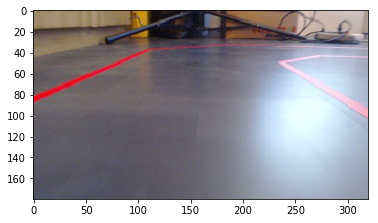

In [9]:
print('X.shape: ', X.shape)
print('Y.shape: ', Y.shape)
imshow(X[0])

In [11]:
def unison_shuffled_copies(X, Y):
    assert len(X) == len(Y)
    p = np.random.permutation(len(X))
    return X[p], Y[p]

shuffled_X, shuffled_Y = unison_shuffled_copies(X,Y)

len(shuffled_X)

5180

In [12]:
test_cutoff = int(len(X) * .8) 
val_cutoff = test_cutoff + int(len(X) * .1)  

train_X, train_Y = shuffled_X[:test_cutoff], shuffled_Y[:test_cutoff]
val_X, val_Y = shuffled_X[test_cutoff:val_cutoff], shuffled_Y[test_cutoff:val_cutoff]
test_X, test_Y = shuffled_X[val_cutoff:], shuffled_Y[val_cutoff:]

len(train_X) + len(val_X) + len(test_X)

5180

In [13]:
X_flipped = np.array([np.fliplr(i) for i in train_X])
Y_flipped = np.array([-i for i in train_Y])
train_X = np.concatenate([train_X, X_flipped])
train_Y = np.concatenate([train_Y, Y_flipped])
len(train_X)

8288

In [14]:
from keras.models import Model, load_model
from keras.layers import Input, Convolution2D, MaxPooling2D, Activation, Dropout, Flatten, Dense

Using TensorFlow backend.


In [15]:
img_in = Input(shape=(180, 320, 3), name='img_in')
angle_in = Input(shape=(1,), name='angle_in')

x = Convolution2D(8, 3, 3)(img_in)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Convolution2D(16, 3, 3)(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Convolution2D(32, 3, 3)(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

merged = Flatten()(x)

x = Dense(256)(merged)
x = Activation('linear')(x)
x = Dropout(.2)(x)

angle_out = Dense(1, name='angle_out')(x)

model = Model(input=[img_in], output=[angle_out])
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

/home/ocp/anaconda3/envs/herbie/lib/python3.5/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (3, 3))`
  after removing the cwd from sys.path.
/home/ocp/anaconda3/envs/herbie/lib/python3.5/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3))`
  
/home/ocp/anaconda3/envs/herbie/lib/python3.5/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3))`
  if sys.path[0] == '':
/home/ocp/anaconda3/envs/herbie/lib/python3.5/site-packages/ipykernel_launcher.py:24: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img_in (InputLayer)          (None, 180, 320, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 178, 318, 8)       224       
_________________________________________________________________
activation_1 (Activation)    (None, 178, 318, 8)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 89, 159, 8)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 87, 157, 16)       1168      
_________________________________________________________________
activation_2 (Activation)    (None, 87, 157, 16)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 43, 78, 16)        0         
__________

In [16]:
import os
from keras import callbacks

model_path = os.path.expanduser('~/best_autopilot.hdf5')

save_best = callbacks.ModelCheckpoint(model_path, monitor='val_loss', verbose=1, 
                                     save_best_only=True, mode='min')
.
early_stop = callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, 
                                     verbose=0, mode='auto')

callbacks_list = [save_best, early_stop]

In [17]:
model.fit(train_X, train_Y, batch_size=64, nb_epoch=4, validation_data=(val_X, val_Y), callbacks=callbacks_list)

/home/ocp/anaconda3/envs/herbie/lib/python3.5/site-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 8288 samples, validate on 518 samples
Epoch 1/4
8288/8288 [==============================] - 491s 59ms/step - loss: 293601.0487 - val_loss: 7.1729

Epoch 00001: val_loss improved from inf to 7.17292, saving model to /home/ocp/best_autopilot.hdf5
Epoch 2/4
8288/8288 [==============================] - 705s 85ms/step - loss: 2.2840 - val_loss: 0.7397

Epoch 00002: val_loss improved from 7.17292 to 0.73972, saving model to /home/ocp/best_autopilot.hdf5
Epoch 3/4
8288/8288 [==============================] - 515s 62ms/step - loss: 0.5167 - val_loss: 0.4871

Epoch 00003: val_loss improved from 0.73972 to 0.48710, saving model to /home/ocp/best_autopilot.hdf5
Epoch 4/4
8288/8288 [==============================] - 538s 65ms/step - loss: 0.4399 - val_loss: 0.4496

Epoch 00004: val_loss improved from 0.48710 to 0.44961, saving model to /home/ocp/best_autopilot.hdf5


In [18]:
import pandas as pd

model = load_model(model_path)
test_P = model.predict(test_X)
test_P = test_P.reshape((test_P.shape[0],)) 

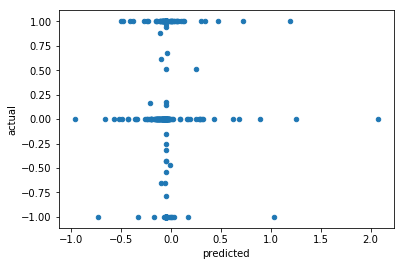

In [19]:
df = pd.DataFrame({'predicted':test_P, 'actual':test_Y})
ax = df.plot.scatter('predicted', 'actual')

Text(0,0.5,'steering angle')

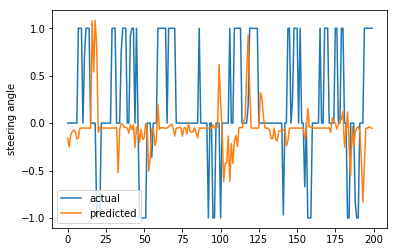

In [23]:
P = model.predict(X[:200])
P = P.reshape((P.shape[0],)) 

ax = pd.DataFrame({'predicted':P, 'actual':Y[:200]}).plot()
ax.set_ylabel("steering angle")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efc346de7b8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7efc34661240>]], dtype=object)

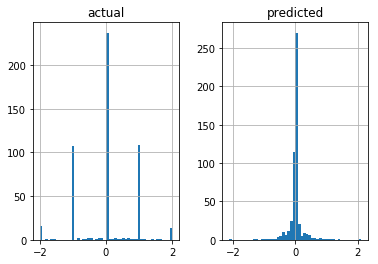

In [25]:
df.diff().hist(bins=50)

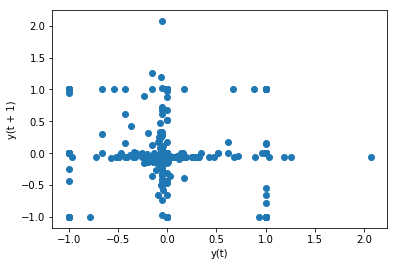

In [26]:
from pandas.plotting import lag_plot
lag_plot(df)

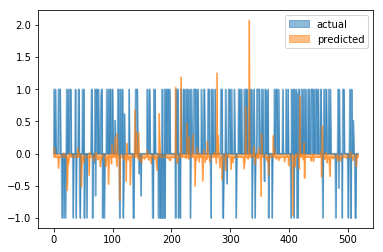

In [28]:
df.plot.area(stacked=False);